
# Decision Boundaries of Multinomial and One-vs-Rest Logistic Regression

This example compares decision boundaries of multinomial and one-vs-rest
logistic regression on a 2D dataset with three classes.

We make a comparison of the decision boundaries of both methods that is equivalent
to call the method `predict`. In addition, we plot the hyperplanes that correspond to
the line when the probability estimate for a class is of 0.5.


In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

## Dataset Generation

We generate a synthetic dataset using :func:`~sklearn.datasets.make_blobs` function.
The dataset consists of 1,000 samples from three different classes,
centered around [-5, 0], [0, 1.5], and [5, -1]. After generation, we apply a linear
transformation to introduce some correlation between features and make the problem
more challenging. This results in a 2D dataset with three overlapping classes,
suitable for demonstrating the differences between multinomial and one-vs-rest
logistic regression.



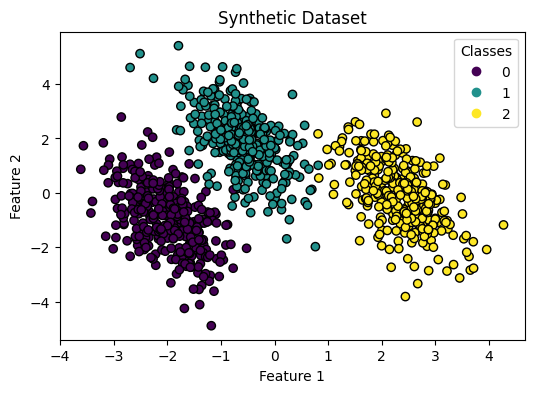

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs

centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1_000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

fig, ax = plt.subplots(figsize=(6, 4))

scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="black")
ax.set(title="Synthetic Dataset", xlabel="Feature 1", ylabel="Feature 2")
_ = ax.legend(*scatter.legend_elements(), title="Classes")

## Classifier Training

We train two different logistic regression classifiers: multinomial and one-vs-rest.
The multinomial classifier handles all classes simultaneously, while the one-vs-rest
approach trains a binary classifier for each class against all others.



In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

logistic_regression_multinomial = LogisticRegression().fit(X, y)
logistic_regression_ovr = OneVsRestClassifier(LogisticRegression()).fit(X, y)

accuracy_multinomial = logistic_regression_multinomial.score(X, y)
accuracy_ovr = logistic_regression_ovr.score(X, y)

## Decision Boundaries Visualization

Let's visualize the decision boundaries of both models that is provided by the
method `predict` of the classifiers.



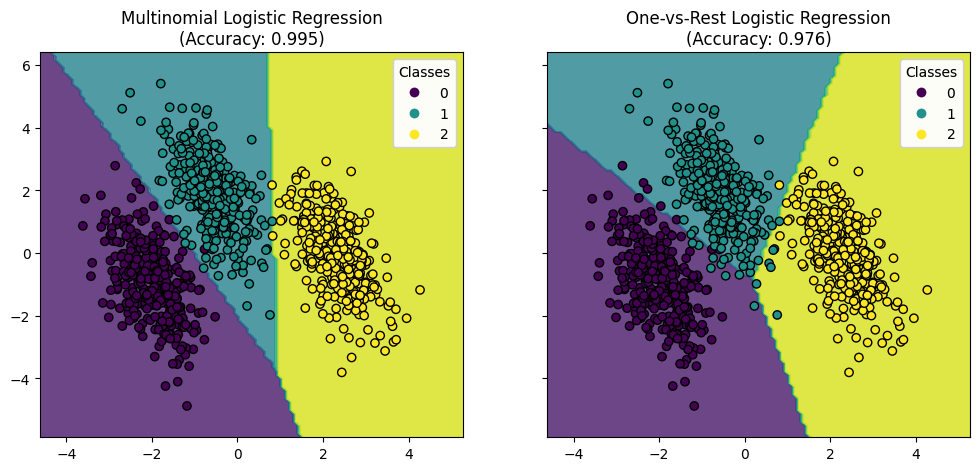

In [3]:
from sklearn.inspection import DecisionBoundaryDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for model, title, ax in [
    (
        logistic_regression_multinomial,
        f"Multinomial Logistic Regression\n(Accuracy: {accuracy_multinomial:.3f})",
        ax1,
    ),
    (
        logistic_regression_ovr,
        f"One-vs-Rest Logistic Regression\n(Accuracy: {accuracy_ovr:.3f})",
        ax2,
    ),
]:
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        ax=ax,
        response_method="predict",
        alpha=0.8,
    )
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
    legend = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend)
    ax.set_title(title)

We see that the decision boundaries are different. This difference stems from their
approaches:

- Multinomial logistic regression considers all classes simultaneously during
  optimization.
- One-vs-rest logistic regression fits each class independently against all others.

These distinct strategies can lead to varying decision boundaries, especially in
complex multi-class problems.

## Hyperplanes Visualization

We also visualize the hyperplanes that correspond to the line when the probability
estimate for a class is of 0.5.



In [4]:
def plot_hyperplanes(classifier, X, ax):
    xmin, xmax = X[:, 0].min(), X[:, 0].max()
    ymin, ymax = X[:, 1].min(), X[:, 1].max()
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

    if isinstance(classifier, OneVsRestClassifier):
        coef = np.concatenate([est.coef_ for est in classifier.estimators_])
        intercept = np.concatenate([est.intercept_ for est in classifier.estimators_])
    else:
        coef = classifier.coef_
        intercept = classifier.intercept_

    for i in range(coef.shape[0]):
        w = coef[i]
        a = -w[0] / w[1]
        xx = np.linspace(xmin, xmax)
        yy = a * xx - (intercept[i]) / w[1]
        ax.plot(xx, yy, "--", linewidth=3, label=f"Class {i}")

    return ax.get_legend_handles_labels()

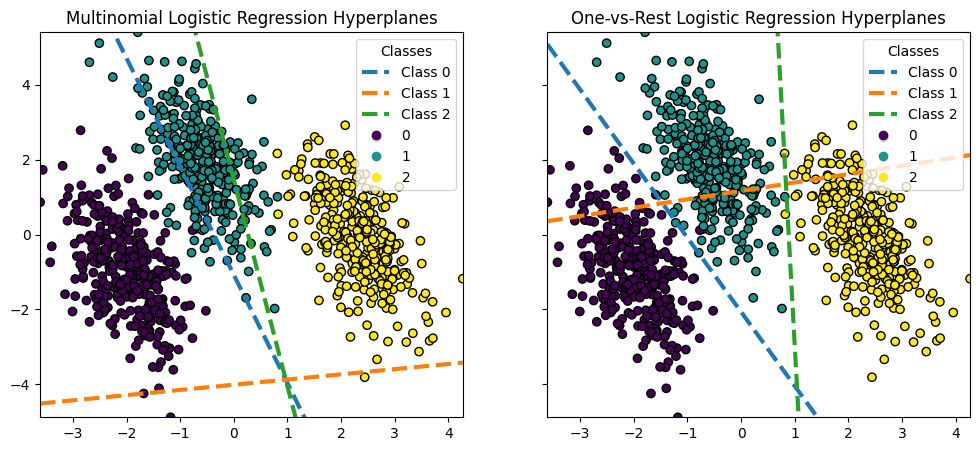

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for model, title, ax in [
    (
        logistic_regression_multinomial,
        "Multinomial Logistic Regression Hyperplanes",
        ax1,
    ),
    (logistic_regression_ovr, "One-vs-Rest Logistic Regression Hyperplanes", ax2),
]:
    hyperplane_handles, hyperplane_labels = plot_hyperplanes(model, X, ax)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
    scatter_handles, scatter_labels = scatter.legend_elements()

    all_handles = hyperplane_handles + scatter_handles
    all_labels = hyperplane_labels + scatter_labels

    ax.legend(all_handles, all_labels, title="Classes")
    ax.set_title(title)

plt.show()

While the hyperplanes for classes 0 and 2 are quite similar between the two methods,
we observe that the hyperplane for class 1 is notably different. This difference stems
from the fundamental approaches of one-vs-rest and multinomial logistic regression:

For one-vs-rest logistic regression:

- Each hyperplane is determined independently by considering one class against all
  others.
- For class 1, the hyperplane represents the decision boundary that best separates
  class 1 from the combined classes 0 and 2.
- This binary approach can lead to simpler decision boundaries but may not capture
  complex relationships between all classes simultaneously.
- There is no possible interpretation of the conditional class probabilities.

For multinomial logistic regression:

- All hyperplanes are determined simultaneously, considering the relationships between
  all classes at once.
- The loss minimized by the model is a proper scoring rule, which means that the model
  is optimized to estimate the conditional class probabilities that are, therefore,
  meaningful.
- Each hyperplane represents the decision boundary where the probability of one class
  becomes higher than the others, based on the overall probability distribution.
- This approach can capture more nuanced relationships between classes, potentially
  leading to more accurate classification in multi-class problems.

The difference in hyperplanes, especially for class 1, highlights how these methods
can produce different decision boundaries despite similar overall accuracy.

In practice, using multinomial logistic regression is recommended since it minimizes a
well-formulated loss function, leading to better-calibrated class probabilities and
thus more interpretable results. When it comes to decision boundaries, one should
formulate a utility function to transform the class probabilities into a meaningful
quantity for the problem at hand. One-vs-rest allows for different decision boundaries
but does not allow for fine-grained control over the trade-off between the classes as
a utility function would.

